In [56]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import text_normalizer as tn
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import tqdm

from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
development = True
if development:
    %matplotlib notebook
else:
    %matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 - Dataset Analysis

## 1.1 - Load the dataset

Load the dataset from a github repository

In [15]:
data = pd.read_csv('https://raw.githubusercontent.com/peppusnight/text_project/master/dataset/dataset_merged.csv')
data_labels_map = dict(enumerate(['Bad','Good']))

Dataset is made of 3000 reviews from 3 different sources: IMDB, AMAZON and YELP<br>(source: https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences#)

In [16]:
corpus, target_labels, target_names = (data.sentence, data.label, 
                                       [data_labels_map[label] for label in data.label])
data_df_total = pd.DataFrame({'reviews': corpus, 'labels': target_labels, 'labels_name': target_names})
print(data_df_total.shape)
data_df_total.head(10)

(3000, 3)


,reviews,labels,labels_name
0,So there is no way for me to plug it in here i...,0,Bad
1,"Good case, Excellent value.",1,Good
2,Great for the jawbone.,1,Good
3,Tied to charger for conversations lasting more...,0,Bad
4,The mic is great.,1,Good
5,I have to jiggle the plug to get it to line up...,0,Bad
6,If you have several dozen or several hundred c...,0,Bad
7,If you are Razr owner...you must have this!,1,Good
8,"Needless to say, I wasted my money.",0,Bad
9,What a waste of money and time!.,0,Bad


Check for empy documents and delete them from the dataset if any

In [17]:
total_nulls = data_df_total[data_df_total.reviews.str.strip() == ''].shape[0]
print("Empty documents:", total_nulls)
data_df_total = data_df_total[~(data_df_total.reviews.str.strip() == '')] # Remove empty docs if any

Empty documents: 0


## 1.2 - Classes distribution

Text(0, 0.5, 'Number of reviews')

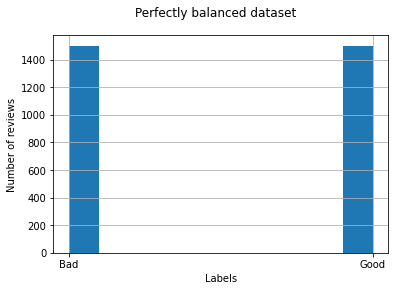

In [18]:
plt.hist(data_df_total.labels_name)
plt.grid()
plt.suptitle('Perfectly balanced dataset')
plt.xlabel('Labels')
plt.ylabel('Number of reviews')

Before perfoming the dataset preprocessing, let's take a quick look at the top "n" words for entire dataset and Bad/Good reviews (bag of words usage) and at the longest and shortest sentence.

In [29]:
corpus = data_df_total.reviews.values.tolist()

vec_corpus = CountVectorizer().fit(corpus)
bag_of_words = vec_corpus.transform(corpus)

n = 10
top_20_all, _, _ = tn.get_top_n_words(corpus, n=n, vec=vec_corpus,bag_of_words=bag_of_words)
top_20_good, _, _ = tn.get_top_n_words(data_df_total.loc[data_df_total.labels.values>0.5,'reviews'].values.tolist(), n=n,
                                   vec=vec_corpus,bag_of_words=bag_of_words)
top_20_bad, _, _ = tn.get_top_n_words(data_df_total.loc[data_df_total.labels.values<0.5,'reviews'].values.tolist(), n=n, 
                                   vec=vec_corpus,bag_of_words=bag_of_words)
pd.DataFrame(data={'top_20_all':top_20_all,'top_20_good':top_20_good,'top_20_bad':top_20_bad})

,top_20_all,top_20_good,top_20_bad
0,"(the, 1953)","(the, 1953)","(the, 1953)"
1,"(and, 1138)","(and, 1138)","(and, 1138)"
2,"(it, 789)","(it, 789)","(it, 789)"
3,"(is, 754)","(is, 754)","(is, 754)"
4,"(to, 670)","(to, 670)","(to, 670)"
5,"(this, 643)","(this, 643)","(this, 643)"
6,"(of, 624)","(of, 624)","(of, 624)"
7,"(was, 571)","(was, 571)","(was, 571)"
8,"(in, 400)","(in, 400)","(in, 400)"
9,"(for, 336)","(for, 336)","(for, 336)"


In [20]:
idx_sort_by_lenght = bag_of_words.sum(axis=1).flatten().argsort()[0]
print('Longest sentence: ')
print('\n')
print(data_df_total.loc[idx_sort_by_lenght[0,-1],'reviews'])
print('\n')
print('Shorted sentence: ')
print('\n')
print(data_df_total.loc[idx_sort_by_lenght[0,0],'reviews'])

Longest sentence: 


This is a masterful piece of film-making, with many themes simmering and occasionally boiling over in this warts and all study of the poet's bohemian, self-indulgent wartime years that span the aerial bombardments of London and the outward tranquillity of a Welsh coastal retreat - the borderlines between friendship, lust and love, dedication to art and experience versus practical concerns, jealousy, rivalry, cowardice and egotism versus heroism and self-sacrifice and more.  


Shorted sentence: 


Horrible!  


From the line above it is clear that we need to preprocess the data in order to find some differences in the dataset; the top n words are almost equal in the three splits.

## 1.3 - Preprocessing

### 1.3.1 Compare lemmatization and stemming
In order to choose which technique to use let's compare the results on random selected sentences

In [21]:
import nltk
stopword_list = nltk.corpus.stopwords.words('english')
# just to keep negation if any in bi-grams
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.sort()
stopword_list

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'sam

In [22]:
# normalize our corpus
norm_corpus_lemm = tn.normalize_corpus(corpus=data_df_total['reviews'],
                                  html_stripping=False, # html stripping not needed here
                                  contraction_expansion=True, # expand contractions (don't_>does not)
                                  accented_char_removal=True, # remove accents from words
                                  text_lower_case=True, # Lower case all sentences
                                  text_lemmatization=True, # Use lemmatization
                                  text_stemming=False, # Do not use stemming
                                  special_char_removal=True, # Remove special characters
                                  remove_digits=True, # Remove digits
                                  stopword_removal=True, # Remove stop words (except no and not)
                                  stopwords=stopword_list)
norm_corpus_stem = tn.normalize_corpus(corpus=data_df_total['reviews'],
                                  html_stripping=False, # html stripping not needed here
                                  contraction_expansion=True, # expand contractions (don't_>does not)
                                  accented_char_removal=True, # remove accents from words
                                  text_lower_case=True, # Lower case all sentences
                                  text_lemmatization=False, # Do not use lemmatization
                                  text_stemming=True, # Use stemming
                                  special_char_removal=True, # Remove special characters
                                  remove_digits=True, # Remove digits
                                  stopword_removal=True, # Remove stop words (except no and not)
                                  stopwords=stopword_list)
norm_corpus_both = tn.normalize_corpus(corpus=data_df_total['reviews'],
                                  html_stripping=False, # html stripping not needed here
                                  contraction_expansion=True, # expand contractions (don't_>does not)
                                  accented_char_removal=True, # remove accents from words
                                  text_lower_case=True, # Lower case all sentences
                                  text_lemmatization=True, # Use lemmatization
                                  text_stemming=True, # Use stemming
                                  special_char_removal=True, # Remove special characters
                                  remove_digits=True, # Remove digits
                                  stopword_removal=True, # Remove stop words (except no and not)
                                  stopwords=stopword_list)
data_df_total['reviews_clean_with_lemm'] = norm_corpus_lemm
data_df_total['reviews_clean_with_stem'] = norm_corpus_stem
data_df_total['reviews_clean_with_both'] = norm_corpus_both

Percentage completed = 20 %
Percentage completed = 40 %
Percentage completed = 60 %
Percentage completed = 80 %
Percentage completed = 100 %
Percentage completed = 20 %
Percentage completed = 40 %
Percentage completed = 60 %
Percentage completed = 80 %
Percentage completed = 100 %
Percentage completed = 20 %
Percentage completed = 40 %
Percentage completed = 60 %
Percentage completed = 80 %
Percentage completed = 100 %


In [23]:
data_df_total = data_df_total[['reviews', 'reviews_clean_with_lemm', 'reviews_clean_with_stem','reviews_clean_with_both','labels', 'labels_name']]
data_df_total.head(10)

,reviews,reviews_clean_with_lemm,reviews_clean_with_stem,reviews_clean_with_both,labels,labels_name
0,So there is no way for me to plug it in here i...,no way plug us unless go converter,no way plug us unless go converter,no way plug us unless go converter,0,Bad
1,"Good case, Excellent value.",good case excellent value,good case excel value,good case excellent value,1,Good
2,Great for the jawbone.,great jawbone,great jawbone,great jawbone,1,Good
3,Tied to charger for conversations lasting more...,tie charger conversation last minute major pro...,tie charger convers last minutes major problems,tie charger conversation last minute major pro...,0,Bad
4,The mic is great.,mic great,mic great,mic great,1,Good
5,I have to jiggle the plug to get it to line up...,jiggle plug get line right get decent volume,jiggl plug get line right get decent volume,jiggle plug get line right get decent volume,0,Bad
6,If you have several dozen or several hundred c...,several dozen several hundred contact imagine ...,sever dozen sever hundr contacts imagin fun se...,several dozen several hundred contact imagine ...,0,Bad
7,If you are Razr owner...you must have this!,razr owner must,razr owner must,razr owner must,1,Good
8,"Needless to say, I wasted my money.",needless say waste money,needless say wast money,needless say waste money,0,Bad
9,What a waste of money and time!.,waste money time,wast money time,waste money time,0,Bad


In [24]:
print('Longest sentence original: ')
print('\n')
print(data_df_total.loc[idx_sort_by_lenght[0,-1],'reviews'])
print('Longest sentence with lemmatization: ')
print('\n')
print(data_df_total.loc[idx_sort_by_lenght[0,-1],'reviews_clean_with_lemm'])
print('\n')
print('Longest sentence with stemming: ')
print('\n')
print(data_df_total.loc[idx_sort_by_lenght[0,-1],'reviews_clean_with_stem'])
print('\n')
print('Longest sentence with both: ')
print('\n')
print(data_df_total.loc[idx_sort_by_lenght[0,-1],'reviews_clean_with_both'])

Longest sentence original: 


This is a masterful piece of film-making, with many themes simmering and occasionally boiling over in this warts and all study of the poet's bohemian, self-indulgent wartime years that span the aerial bombardments of London and the outward tranquillity of a Welsh coastal retreat - the borderlines between friendship, lust and love, dedication to art and experience versus practical concerns, jealousy, rivalry, cowardice and egotism versus heroism and self-sacrifice and more.  
Longest sentence with lemmatization: 


masterful piece film making many theme simmer occasionally boil wart study poet bohemian self indulgent wartime year span aerial bombardment london outward tranquillity welsh coastal retreat borderline friendship lust love dedication art experience versus practical concern jealousy rivalry cowardice egotism versus heroism self sacrifice


Longest sentence with stemming: 


thi master piec filmmaking mani theme simmer occasion boil thi wart studi 

To select which one (or both) to use it's not trivial; in this review the most useful sentence is probably "masterful piece" that is kept in both techniques. <br>
We decided to use the stemming (NOTE SE NON RIESCI A CLASSIFICARE BENE PROVA ANCHE L'ALTRO).

In [25]:
data_df_total['reviews_clean'] = data_df_total['reviews_clean_with_stem']
data_df = data_df_total[['reviews', 'reviews_clean', 'labels', 'labels_name']]
data_df.head(10)

,reviews,reviews_clean,labels,labels_name
0,So there is no way for me to plug it in here i...,no way plug us unless go converter,0,Bad
1,"Good case, Excellent value.",good case excel value,1,Good
2,Great for the jawbone.,great jawbone,1,Good
3,Tied to charger for conversations lasting more...,tie charger convers last minutes major problems,0,Bad
4,The mic is great.,mic great,1,Good
5,I have to jiggle the plug to get it to line up...,jiggl plug get line right get decent volume,0,Bad
6,If you have several dozen or several hundred c...,sever dozen sever hundr contacts imagin fun se...,0,Bad
7,If you are Razr owner...you must have this!,razr owner must,1,Good
8,"Needless to say, I wasted my money.",needless say wast money,0,Bad
9,What a waste of money and time!.,wast money time,0,Bad


After the cleaning, there might be some emtpy document; let's use regular expression to delete them.

In [26]:
data_df = data_df.replace(r'^(\s?)+$', np.nan, regex=True)
data_df.info()
data_df = data_df.dropna().reset_index(drop=True)
data_df.info()
data_df.to_csv('dataset_merged_cleaned.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviews        3000 non-null   object
 1   reviews_clean  2998 non-null   object
 2   labels         3000 non-null   int64 
 3   labels_name    3000 non-null   object
dtypes: int64(1), object(3)
memory usage: 181.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998 entries, 0 to 2997
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviews        2998 non-null   object
 1   reviews_clean  2998 non-null   object
 2   labels         2998 non-null   int64 
 3   labels_name    2998 non-null   object
dtypes: int64(1), object(3)
memory usage: 93.8+ KB


In [42]:
corpus = data_df.reviews_clean.values
vec_corpus_clean = CountVectorizer().fit(corpus)
bag_of_words_clean = vec_corpus_clean.transform(corpus)

Plot term frequency on both original and cleaned dataset.

<IPython.core.display.Javascript object>


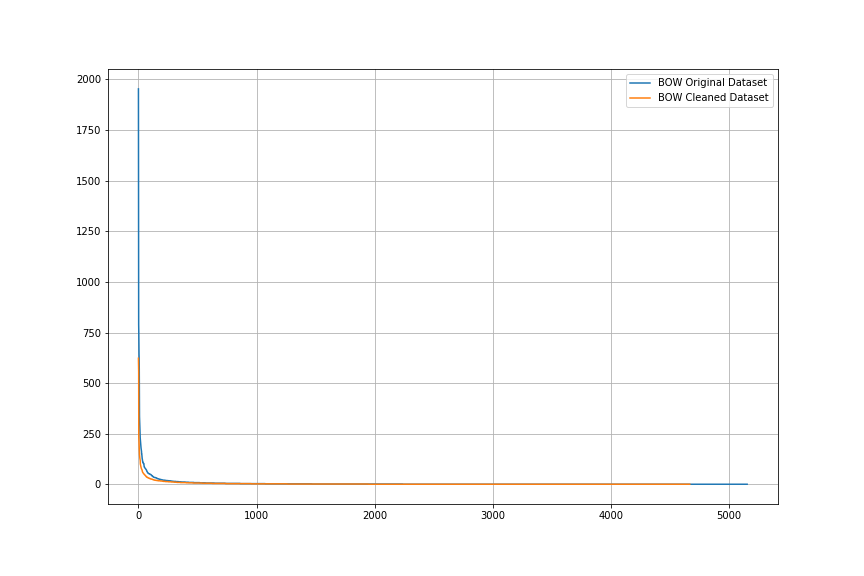

In [61]:
bow_clean = bag_of_words_clean.sum(axis=0).tolist()[0]; bow_clean.sort(reverse=True)
bow = bag_of_words.sum(axis=0).tolist()[0]; bow.sort(reverse=True)
plt.figure(figsize=(12,8))
plt.plot(bow, label='BOW Original Dataset')
plt.plot(bow_clean, label='BOW Cleaned Dataset')
plt.grid()
plt.legend()